In [1]:
# !pip install glrlm
# !pip install -U scikit-image
# !pip install -U scikit-optimize

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
from glrlm import GLRLM
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern

from sklearn.preprocessing import MinMaxScaler

In [5]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Ciencia_de_dados_em_Saude/P4-Imagens/Train/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Group:

Name: Alexandre Dias Negretti RA: 233609

Name: Daniel Godoy Marques RA: 166213

Name: Gyovana Mayara Moriyama RA: 216190

Auxiliary methods

In [6]:
#Method that loads imagens given a names list
def get_image(img_list:list, path):
  l = []
  for image in img_list:
    img = Image.open(path + image)
    f = np.array(img, dtype=np.uint8)
    l.append(f)
  return l

In [7]:
#Method to print a image
def print_image(image: np.array, title:str):
  plt.title(title)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

In [25]:
#Method that returns the axis of the first occurence of a non zero value
def get_axis(img):
  positions = np.nonzero(img)

  if len(positions[0]) > 0 and len(positions[1]) > 0:
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()

    if top-5 >= 0:
      top -= 5
    else:
      top = 0
    if bottom+5 < img.shape[0]:
      bottom += 5
    else:
      bottom = img.shape[0] - 1
    if left-5 >= 0:
      left -= 5
    else:
      left = 0
    if right < img.shape[1]:
      right += 5 
    else:
      right = img.shape[1] - 1
    
  else: 
    top = 0
    bottom = img.shape[0] - 1
    left = 0
    right = img.shape[1] - 1
    
  return top, bottom, left, right

In [26]:
#Method that converts a mask values to binary
def convert_mask(mask):
  imgm_copy = mask.copy()
  im_cv2 = np.asarray(imgm_copy)
  thresh = mask.min()
  im_bw = cv2.threshold(im_cv2, thresh, 1, cv2.THRESH_BINARY)[1]
  im_pil = Image.fromarray(im_bw)
  f = np.array(im_pil, dtype=np.uint8)

  return f

In [31]:
#Method that returns the cropped image in order to approximate the mask region
def get_mask_area(img, mask):
  if mask.max() > 0:
    mask_bin = convert_mask(mask)
    img_masked = img * mask_bin
    top, bottom, left, right = get_axis(img_masked)
    imgm_crop = img_masked[top:bottom, left:right]
    f = np.array(imgm_crop, dtype=np.uint8)
  else:
    f = img
  return f.astype(dtype=np.uint8)

In [11]:
#Method that returns the extracted properties from glcm
def get_glcm_properties(img, dists,  angles):

  glcm = graycomatrix(img, distances=[dists], angles=[angles], levels=256, symmetric=True, normed=True)
  contrast = graycoprops(glcm, prop='contrast')
  dissimilarity = graycoprops(glcm, prop='dissimilarity')
  homogeneity = graycoprops(glcm, prop='homogeneity')
  ASM = graycoprops(glcm, prop='ASM')
  energy = graycoprops(glcm, prop='energy')
  correlation = graycoprops(glcm, prop='correlation')

  return contrast, dissimilarity, homogeneity, ASM, energy, correlation 


In [12]:
#Method that returns LBP histogram values
def get_lbp(img, radius, METHOD, bins=30):
  n_points = 8 * radius
  lbp = local_binary_pattern(img, n_points, radius, METHOD)
  h, bins_edges = np.histogram(lbp, bins=bins)

  return lbp, h, bins_edges

In [13]:
#Method that reads a txt file and returns a list with file content
def file_to_list(file_path: str) -> list:
    my_file = open(file_path, "r")
    content = my_file.read()
    file_list = content.split("\n")
    my_file.close()

    return file_list

In [14]:
#Method that extracts image attributes and inserts them in a pandas Dataframe
def get_features(img_list, df):
  for i, _ in enumerate(img_list):
    nbins = 20
    img = img_list[i]
    #histogram
    h, bin_edges = np.histogram(a=img, bins=nbins, range=(0,255))
    nobs, minmax, mean, var, skew, kurtosis =  stats.describe(h)
    contrast, dissimilarity, homogeneity, ASM, energy, correlation = get_glcm_properties(img, 1, 0)
    df.loc[i, 'max'] = minmax[1]
    df.loc[i, 'mean'] = mean
    df.loc[i, 'var'] = var
    df.loc[i, 'skew'] = skew
    df.loc[i, 'kurtosis'] = kurtosis

    #GLCM
    df.loc[i, 'contrast'] = contrast[0]
    df.loc[i, 'dissimilarity'] = dissimilarity[0]
    df.loc[i, 'homogeneity'] = homogeneity[0]
    df.loc[i, 'ASM'] = ASM[0]
    df.loc[i, 'energy'] = energy[0]
    df.loc[i, 'correlation'] = correlation[0]

    #GLRLM
    imgm_copy = img.copy()
    im_cv2 = np.asarray(imgm_copy)
    app = GLRLM()
    SRE, LRE, GLU, RLU, RPC = app.get_features(im_cv2, level=8).Features
    df.loc[i, 'SRE'] = SRE
    df.loc[i, 'LRE'] = LRE
    df.loc[i, 'GLU'] = GLU
    df.loc[i, 'RLU'] = RLU
    df.loc[i, 'RPC'] = RPC

    #LBP histogram
    lbp, hm, binsm = get_lbp(img, 1, 'uniform', 30)
    for j, bin in enumerate(hm):
      df.loc[i, 'lbp_bin' + str(j)] = bin
    
  return df

Loads the images and the masks

In [13]:
#Load the files that contains the names of the images to load
em_imgs = file_to_list(path + 'EM/em_imgs.txt')
em_masks = file_to_list(path + 'EM/em_masks.txt')
avc_imgs = file_to_list(path + 'AVC/avc_imgs.txt')
avc_masks = file_to_list(path + 'AVC/avc_masks.txt')

In [14]:
#Load the images
em_img_list = get_image(em_imgs, path + 'EM/')
em_mask_list = get_image(em_masks, path + 'EM/')

avc_img_list = get_image(avc_imgs, path + 'AVC/')
avc_mask_list = get_image(avc_masks, path + 'AVC/')

Apply normalization.

As for normalization, we were between the Median Mad without intensity transformation, since by the tests performed, it was the one that presented the best result (it enhanced the lesion but without taking away the characteristics of the original image) and the Min Max without intensity transformation, which also presented similar results. However, we chose to use Min Max since as we have more than 50% of the pixels of the same value, the MAD becomes zero, causing the Median Mad to return nan or inf, making it impossible to use it in several images. The choice was made both by observing the image and the histogram, since in it we can see that there is a greater quantity/importance in the lighter levels.

Tests performed with other combinations of intensity transformation and normalization did not show satisfactory results, since most of the image characteristics were lost or the lesion region was lost, which is not good for our problem.

In [15]:
em_norm_list = []
avc_norm_list = []

minmax = MinMaxScaler([0,1])
for img in em_img_list:  
  em_norm_list.append(minmax.fit_transform(img))

for img in avc_img_list:
  avc_norm_list.append(minmax.fit_transform(img))

Here we apply the mask in the images and crop image in order to approximate the mask region

In [16]:
em_list = []
avc_list = []
for img, mask in zip(em_img_list, em_mask_list):
  em_list.append(get_mask_area(img, mask))

for img, mask in zip(avc_img_list, avc_mask_list):
  avc_list.append(get_mask_area(img, mask))

Here we create the dataframe the will be used as input on the classifier.

ischemic (AVC) -> 1

demyelinating (EM) -> 0

In [17]:
# 0 = em, 1 = avc
em_df = pd.DataFrame()
avc_df = pd.DataFrame()

em_ids = [id[0:3] for id in em_imgs]
avc_ids = [id[0:3] for id in avc_imgs]

for i, id in enumerate(em_ids):
  em_df.loc[i, 'id'] = id
  em_df.loc[i, 'target'] = 0

for i, id in enumerate(avc_ids):
  avc_df.loc[i, 'id'] = id
  avc_df.loc[i, 'target'] = 1

Here we create the features with the extracted attributes from images.

In [18]:
em_df = get_features(em_list, em_df)

In [19]:
avc_df = get_features(avc_list, avc_df)

In [20]:
df = pd.concat([em_df, avc_df], ignore_index=True)
df.head()

,id,target,max,mean,var,skew,kurtosis,contrast,dissimilarity,homogeneity,...,lbp_bin20,lbp_bin21,lbp_bin22,lbp_bin23,lbp_bin24,lbp_bin25,lbp_bin26,lbp_bin27,lbp_bin28,lbp_bin29
0,060,0.0,7964.0,425.45,3.149221e+06,4.127825,15.044006,414.138153,2.890718,0.934052,...,4.0,0.0,0.0,2.0,0.0,0.0,7964.0,0.0,0.0,11.0
1,060,0.0,34594.0,1773.20,5.968427e+07,4.128870,15.049438,105.858662,0.874979,0.975130,...,8.0,0.0,0.0,2.0,0.0,0.0,34594.0,0.0,0.0,27.0
2,060,0.0,39162.0,1974.00,7.661812e+07,4.129435,15.052381,83.983641,0.536170,0.991343,...,6.0,0.0,0.0,1.0,0.0,0.0,39163.0,0.0,0.0,19.0
3,060,0.0,36849.0,1922.80,6.759010e+07,4.128571,15.047883,188.833861,1.468419,0.958865,...,38.0,0.0,0.0,14.0,0.0,0.0,36862.0,0.0,0.0,52.0
4,060,0.0,30294.0,1643.00,4.550758e+07,4.125044,15.029442,238.324063,1.952646,0.928578,...,75.0,0.0,0.0,34.0,0.0,0.0,30322.0,0.0,0.0,49.0


In [21]:
df.to_csv(path + 'final_df.csv', index=False)

## SVM Model

In [39]:
df = pd.read_csv(path + 'final_df.csv')
df

,id,target,max,mean,var,skew,kurtosis,contrast,dissimilarity,homogeneity,...,lbp_bin20,lbp_bin21,lbp_bin22,lbp_bin23,lbp_bin24,lbp_bin25,lbp_bin26,lbp_bin27,lbp_bin28,lbp_bin29
0,60,0.0,7964.0,425.45,3.149221e+06,4.127825,15.044006,414.138153,2.890718,0.934052,...,4.0,0.0,0.0,2.0,0.0,0.0,7964.0,0.0,0.0,11.0
1,60,0.0,34594.0,1773.20,5.968427e+07,4.128870,15.049438,105.858662,0.874979,0.975130,...,8.0,0.0,0.0,2.0,0.0,0.0,34594.0,0.0,0.0,27.0
2,60,0.0,39162.0,1974.00,7.661812e+07,4.129435,15.052381,83.983641,0.536170,0.991343,...,6.0,0.0,0.0,1.0,0.0,0.0,39163.0,0.0,0.0,19.0
3,60,0.0,36849.0,1922.80,6.759010e+07,4.128571,15.047883,188.833861,1.468419,0.958865,...,38.0,0.0,0.0,14.0,0.0,0.0,36862.0,0.0,0.0,52.0
4,60,0.0,30294.0,1643.00,4.550758e+07,4.125044,15.029442,238.324063,1.952646,0.928578,...,75.0,0.0,0.0,34.0,0.0,0.0,30322.0,0.0,0.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,51,1.0,5559.0,568.70,1.728431e+06,3.155564,8.923430,1112.084955,8.217187,0.701509,...,245.0,0.0,0.0,349.0,0.0,0.0,7219.0,0.0,0.0,155.0
1207,51,1.0,5574.0,436.10,1.633189e+06,3.564786,11.577003,1119.205241,7.265538,0.822487,...,101.0,0.0,0.0,234.0,0.0,0.0,6741.0,0.0,0.0,67.0
1208,51,1.0,3455.0,262.80,6.423251e+05,3.493895,11.089721,1509.698630,8.194868,0.858035,...,40.0,0.0,0.0,160.0,0.0,0.0,4223.0,0.0,0.0,22.0
1209,51,1.0,2803.0,183.00,3.974279e+05,3.872244,13.543232,1692.340650,8.570158,0.878645,...,28.0,0.0,0.0,81.0,0.0,0.0,3055.0,0.0,0.0,43.0


Here, we reduced the number of features, since most of the features generated by the LBP histogram have many zeros, leaving the matrix very sparse and disturbing the model, so we took the columns in which the ratio of values ​​is less than 10 (threshold to not eliminate so many columns) and remove them.

In [40]:
cols_lbp = ['lbp_bin0', 'lbp_bin1', 'lbp_bin2',
       'lbp_bin3', 'lbp_bin4', 'lbp_bin5', 'lbp_bin6', 'lbp_bin7', 'lbp_bin8',
       'lbp_bin9', 'lbp_bin10', 'lbp_bin11', 'lbp_bin12', 'lbp_bin13',
       'lbp_bin14', 'lbp_bin15', 'lbp_bin16', 'lbp_bin17', 'lbp_bin18',
       'lbp_bin19', 'lbp_bin20', 'lbp_bin21', 'lbp_bin22', 'lbp_bin23',
       'lbp_bin24', 'lbp_bin25', 'lbp_bin26', 'lbp_bin27', 'lbp_bin28',
       'lbp_bin29']

cols_to_drop = []
for col in cols_lbp:
  ratio = df[col].sum() / df.shape[0]
  if ratio < 10:
    cols_to_drop.append(col)

In [41]:
df.drop(cols_to_drop, axis=1, inplace=True)

Here we split into train and validation, so that the same patient is not in training and validation at the same time.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df[['id']].drop_duplicates(), test_size=0.3, random_state=42, shuffle=True)

df_x_train = df[df['id'].isin(X_train['id'].tolist())].copy()
df_x_test = df[df['id'].isin(X_test['id'].tolist())].copy()

df_y_train = df_x_train['target']
df_y_test = df_x_test['target']

df_x_train.drop(['target', 'id'], axis=1, inplace=True)
df_x_test.drop(['target', 'id'], axis=1, inplace=True)

columns = df_x_train.columns

Here we apply a Standard Scaler to normalize the data.

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_x_train = scaler.fit_transform(df_x_train)
df_x_test = scaler.transform(df_x_test)

Here we apply a GridSearch to optimize the hyperparameters.

{'C': 1000, 'max_iter': 1000}
LinearSVC(C=1000, dual=False, random_state=42)
Acurácia: 0.8954423592493298


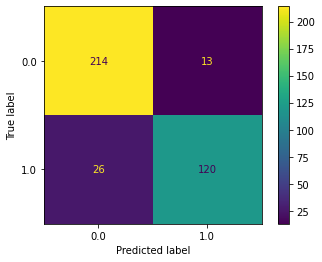

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import scipy

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'max_iter': [1000, 2000, 3000, 4000, 5000, 10000],
              }
 
grid = GridSearchCV(LinearSVC(dual=False, random_state=42), param_grid, refit = True, cv=5, n_jobs=-1)

grid.fit(df_x_train, df_y_train)

y_grid_pred = grid.predict(df_x_test)

print(grid.best_params_)
print(grid.best_estimator_)


print(f'Acurácia: {accuracy_score(df_y_test, y_grid_pred)}')
ConfusionMatrixDisplay.from_predictions(df_y_test, y_grid_pred) 

Here we train the Linear SVC model using the best parameters obtained on GridSearch and print accuracy and confusion matrix for the validation data.

Acurácia: 0.8954423592493298


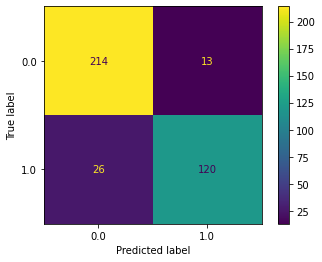

In [45]:
model = LinearSVC(C=1000, dual=False, random_state=42)
model.fit(df_x_train, df_y_train)
y_pred = model.predict(df_x_test)

print(f'Acurácia: {accuracy_score(df_y_test, y_pred)}')
ConfusionMatrixDisplay.from_predictions(df_y_test, y_pred) 

Here we show the features importance. In the plot, we can see which features were most important in the prediction.

In [46]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(15,7))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.tight_layout()
    plt.show()

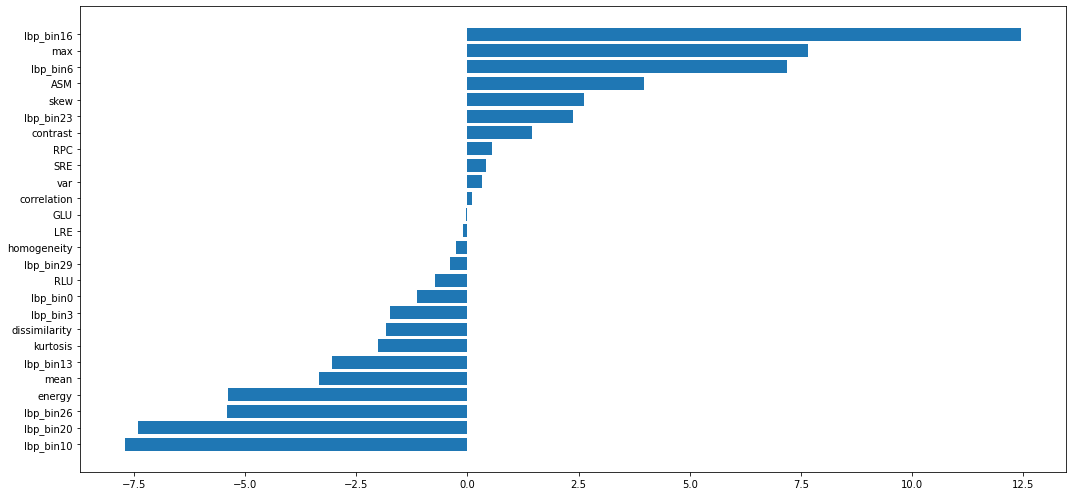

In [47]:
f_importances(model.coef_[0], columns.tolist())

## SLE Prediction

In [62]:
path_test = '/content/drive/MyDrive/Ciencia_de_dados_em_Saude/P4-Imagens/SLE/'
test_imgs = file_to_list(path_test + 'sle_imgs.txt')
test_masks = file_to_list(path_test + 'sle_masks.txt')

In [63]:
test_img_list = get_image(test_imgs, path_test)
test_mask_list = get_image(test_masks, path_test)


In [64]:
test_norm_list = []

minmax = MinMaxScaler([0,1])
for img in test_img_list:  
  test_norm_list.append(minmax.fit_transform(img))

In [65]:
test_list = []
for img, mask in zip(test_norm_list, test_mask_list):
  test_list.append(get_mask_area(img, mask))

In [66]:
# 0 = em, 1 = avc
test_df = pd.DataFrame()

test_ids = [id[0:3] for id in test_imgs]

for i, id in enumerate(test_ids):
  test_df.loc[i, 'id'] = id

In [67]:
test_df = get_features(test_list, test_df)

In [68]:
test_df

,id,max,mean,var,skew,kurtosis,contrast,dissimilarity,homogeneity,ASM,...,lbp_bin20,lbp_bin21,lbp_bin22,lbp_bin23,lbp_bin24,lbp_bin25,lbp_bin26,lbp_bin27,lbp_bin28,lbp_bin29
0,600,5280.0,264.00,1393920.00,4.129483,15.052632,0.003429,0.003429,0.998286,0.990507,...,0.0,0.0,0.0,0.0,0.0,0.0,5264.0,0.0,0.0,5.0
1,600,9185.0,459.25,4218211.25,4.129483,15.052632,0.001972,0.001972,0.999014,0.995407,...,0.0,0.0,0.0,0.0,0.0,0.0,9173.0,0.0,0.0,1.0
2,600,6697.0,334.85,2242490.45,4.129483,15.052632,0.004805,0.004805,0.997598,0.990425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6681.0
3,600,33672.0,1683.60,56690179.20,4.129483,15.052632,0.000836,0.000836,0.999582,0.998090,...,0.0,0.0,0.0,0.0,0.0,0.0,33654.0,0.0,0.0,1.0
4,600,12780.0,639.00,8166420.00,4.129483,15.052632,0.001270,0.001270,0.999365,0.997463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,677,182.0,9.10,1656.20,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693,677,132.0,6.60,871.20,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,678,10672.0,533.60,5694579.20,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,678,10434.0,521.70,5443417.80,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
test_df.drop(cols_to_drop + ['id'], axis=1, inplace=True)

In [70]:
test_df

,max,mean,var,skew,kurtosis,contrast,dissimilarity,homogeneity,ASM,energy,...,lbp_bin0,lbp_bin3,lbp_bin6,lbp_bin10,lbp_bin13,lbp_bin16,lbp_bin20,lbp_bin23,lbp_bin26,lbp_bin29
0,5280.0,264.00,1393920.00,4.129483,15.052632,0.003429,0.003429,0.998286,0.990507,0.995242,...,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5264.0,5.0
1,9185.0,459.25,4218211.25,4.129483,15.052632,0.001972,0.001972,0.999014,0.995407,0.997701,...,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,9173.0,1.0
2,6697.0,334.85,2242490.45,4.129483,15.052632,0.004805,0.004805,0.997598,0.990425,0.995201,...,14.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6681.0
3,33672.0,1683.60,56690179.20,4.129483,15.052632,0.000836,0.000836,0.999582,0.998090,0.999045,...,11.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,33654.0,1.0
4,12780.0,639.00,8166420.00,4.129483,15.052632,0.001270,0.001270,0.999365,0.997463,0.998731,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,182.0,9.10,1656.20,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693,132.0,6.60,871.20,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,10672.0,533.60,5694579.20,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,10434.0,521.70,5443417.80,4.129483,15.052632,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
test_df = scaler.transform(test_df)

In [72]:
y_test_pred = model.predict(test_df)

In [73]:
df_test_y = pd.DataFrame()

# 0 = em, 1 = avc
for i, id in enumerate(test_ids):
  df_test_y.loc[i, 'id'] = id

df_test_y['pred'] = y_test_pred
df_test_y['pred'] = df_test_y['pred'].apply(lambda x: 'AVC' if x == 1.0 else 'EM')
df_test_y

,id,pred
0,600,EM
1,600,EM
2,600,EM
3,600,EM
4,600,EM
...,...,...
692,677,EM
693,677,EM
694,678,AVC
695,678,AVC


In [74]:
with open(path_test+'test_preds.txt', 'w') as f:
  for i in range(len(df_test_y)):
    id , pred = df_test_y.iloc[i]
    f.write(str(id) + " " + pred)
    f.write('\n')